# An Online Product Recomendation System

This project builds a recomendation system using a unique approach. Word2vec, an NLP concept is used to recommend products to customers

Toolkits: The project heavily relies on an NLP algorithm; word2vec, pandas and numpy for data wrangling, analysis, and modelling. The primary plotting library used is Matplotlib.

Dataset: Online Retail - it is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

1. Importing the required libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.manifold import TSNE

import warnings;
warnings.filterwarnings('ignore')


2. Loading the data into the data frame.

In [2]:
# load data
data = pd.read_csv('Online Retail.csv', encoding='unicode_escape')
df = data.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom


3. Data cleaning and preparation

In [3]:
# check dimensions of/ number of entries in the dataset
print(df.shape)

# This is large enough to build our model

(541909, 8)


In [4]:
# check types of data
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
# convert CustomerID to integer datatype
df.CustomerID = df.CustomerID.astype('Int64')
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID       Int64
Country         object
dtype: object

In [6]:
# check and drop duplicate rows
print('Duplicate rows before: ',df[df.duplicated()].shape)
df.drop_duplicates(inplace=True)
print('Duplicate rows after: ',df[df.duplicated()].shape)

Duplicate rows before:  (5268, 8)
Duplicate rows after:  (0, 8)


In [7]:
# examine data for missing values
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


since we have enough data, let us drop rows with missing values

In [8]:
df.dropna(inplace=True)
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


let's check number of entries in our data after treating duplicates and row with missing values

In [9]:
print('Number of entries after cleaning:\n', df.shape)

Number of entries after cleaning:
 (401604, 8)


Let's check the number of unique customers in our data

In [10]:

customers = list(set(df.CustomerID))
len(customers)



4372

There are 4372 in our dataset. The buying history of each of these customers will be extracted 
resulting in 4372 sequences of purchase

Let's split our dataset into training set and validation set
90% of the custmors will be used to create word embeddings using word2vec and 10% will be used to fine-tune the model's parameters

In [11]:
# Let's shuffle customers Id  to eliminate biasness
random.shuffle(customers)

# Lets extract 90% of Custormer IDs
customer_train = [customers[customer] for customer in range(round(0.9*len(customers)))]

# split data into train and validation set
df_train = df[df.CustomerID.isin(customer_train)]
df_val = df[~df.CustomerID.isin(customer_train)]

print('Train set dim: ',df_train.shape)
print('Validation set dim: ',df_val.shape)

Train set dim:  (356651, 8)
Validation set dim:  (44953, 8)


Let's us create purchases sequences made by customers both in train and validation set

In [12]:
# get Purchase history of customers in train set using stockcode(products bought)
purchase_seq_train = []
for customer in customer_train:
    k = df_train[df_train['CustomerID'] == customer]['StockCode'].tolist()
    purchase_seq_train.append(k)

# get Purchase history of customers in validation set using stockcode(products bought)
purchase_seq_val = []
for customer in df_val['CustomerID'].unique():
    k = df_val[df_val['CustomerID'] == customer]['StockCode'].tolist()
    purchase_seq_val.append(k)

4. Building and Applying word2vec Model

Now let's build and apply word2vec embeddings for/to products

In [13]:
# train model
model = word2vec.Word2Vec(window=10,   # context window
                 sg=1,        # 1 for skip gram; otherwise cbow
                 hs=0,
                 negative=10, # how many negative samples should be drawn
                 alpha=0.03,
                 min_alpha=0.0007,
                 seed=14)

model.build_vocab(purchase_seq_train, progress_per=200)
model.train(purchase_seq_train, total_examples=model.corpus_count,
             epochs=10,
             report_delay=1)

# model summary
print(model)

Word2Vec<vocab=3167, vector_size=100, alpha=0.03>


There are vocabulary of 3167 unique words in our model with vector size 100 for each
Now let us extract the vector of all the words and store it in a variable for easy access

In [14]:
# get the word forms of the vocabulary
words = model.wv.index_to_key
# get embeddings of all word forms
vectors = model.wv[words]
vectors.shape

(3167, 100)

5. Visualization

Let's visualize word2vec embeddings

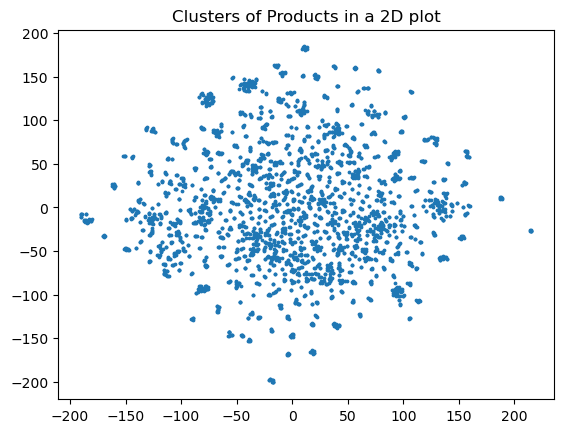

In [15]:

# firstly, let us reduce the dimensions of our embeddings from 100 to 2 using TSNE()
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)

dim2_embeddings = tsne.fit_transform(vectors)

# Next visulization
np.set_printoptions(suppress=True)
# plt.figure(figsize=(12, 6))
plt.scatter(dim2_embeddings[:, 0], dim2_embeddings[:, 1], s=3, cmap='Spectral')
plt.title('Clusters of Products in a 2D plot')
plt.show()

Every dot in the plot is a product, As seen, there are several clusters of data points showing groups of similar products

6. Product Recommendation


Now that our word2vec embeddings for every product in the dataset is ready, the next step is to suggest similar products for a certain product or a product’s vector.

In [16]:
# Firstly, let's create a product-ID and product-description dictionary 
# to easily map a product’s description to its ID and vice versa.

products = df_train[['StockCode', 'Description']]

# drop duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

Trying out the dictionary

In [17]:
products_dict['85123A']

['CREAM HANGING HEART T-LIGHT HOLDER']

Perfect!
Now let's define a function that will take a product’s vector (v) as input and return top 5 similar products


In [18]:
def similar_products(v, n = 5):
    
    # extract most similar products for the input vector
    model_sim = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    model_sim_n = [(products_dict[i[0]][0], i[1]) for i in model_sim] 
    return model_sim_n

Let's check our fuction by passing the vector of the product ‘84029G’
(‘KNITTED UNION FLAG HOT WATER BOTTLE’)

In [19]:
similar_products(model.wv['84029G'])

[('RED WOOLLY HOTTIE WHITE HEART.', 0.8196043968200684),
 ('WHITE SKULL HOT WATER BOTTLE ', 0.7424203157424927),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.7300752997398376),
 ('RETROSPOT HEART HOT WATER BOTTLE', 0.7241225242614746),
 ('CHOCOLATE HOT WATER BOTTLE', 0.7165784239768982)]

As seen, the results are pretty relevant and match well with the input product. 
However, this output is based on the vector of a single product only. 
Let's take this further by creating a function to recommend products based on the multiple purchases a customer has made in the past.
To do this, we will take the average of all the vectors of the products the customer has bought and use this resultant vector to find similar product

The fuction will take a list of product IDs and return a 100-dimensional vector which is a mean of the vectors of the products in the input list

In [20]:
def aggregate_vectors(products):
    product_vector = []
    for n in products:
        try:
            product_vector.append(model.wv[n])
        except KeyError:
            continue
    
    return np.mean(product_vector, axis=0)

Now let us make use of the purchase sequences validation set we created earlier

In [21]:
len(purchase_seq_val[0])

196

The length of the first list of products purchased by a customer is 196. 
Let's pass these products’ sequence of the validation set to the function aggregate_vectors

In [22]:
aggregate_vectors(purchase_seq_val[1]).shape

(100,)

The function returned an array of 100 dimensions, which means it is working fine. Now we can use this result to get the most similar products

In [23]:

similar_products(aggregate_vectors(purchase_seq_val[1]))

[('SET OF 20 VINTAGE CHRISTMAS NAPKINS', 0.6570705771446228),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.652031660079956),
 ('CHRISTMAS CRAFT WHITE FAIRY ', 0.6429521441459656),
 ('CHRISTMAS CRAFT TREE TOP ANGEL', 0.6240510940551758),
 ('MINI PAINT SET VINTAGE ', 0.62189781665802)]

Cool! Our system recommended 5 products based on the entire purchase history of a customer.

To get product suggestions based on the last few purchases, let's use the same set of functions.
Passing only the last 10 products purchased as input

In [24]:
similar_products(aggregate_vectors(purchase_seq_val[1][-10:]))

[('GARDENERS KNEELING PAD KEEP CALM ', 0.6959453225135803),
 ('CHRISTMAS CRAFT WHITE FAIRY ', 0.6628435850143433),
 ('ROTATING SILVER ANGELS T-LIGHT HLDR', 0.6533429026603699),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.6397597789764404),
 ('CHRISTMAS CRAFT TREE TOP ANGEL', 0.6327142119407654)]

6. Conclusion

Finally! We succefully used an NLP algorithm called word2vec on a non-textual sequence data to build a product recommendation system based on customer purchase history